# Example: Crosstalk Methodology

Last Verified to Run: 2023-04-25\
Verified Stack Release: w_2023_15

## Introduction

The purpose of this notebook is to demonstrate the methodology used by the MixCOATL crosstalk analysis to calculate the crosstalk ratio results between amplifier pairs. This is done by using the Butler to obtain an example image from a Gen 3 repository and then running the crosstalk analysis code that is implemented in `mixcoatl.crosstalkTask.CrosstalkTask`.

For a detailed example on interacting with a Gen 3 repository and exploring the crosstalk analysis data products, see the notebook `Example_CrosstalkResults.ipynb`.

In [1]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   gdf42428520+6e1f2e8f29 	current w_latest w_2023_15 setup


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import numpy as np
from scipy.stats import binned_statistic

## DM Stack imports
from lsst.daf.butler import Butler
from lsst.afw.detection import FootprintSet, Threshold
from lsst.ip.isr import CrosstalkCalib

## MixCOATL imports
from mixcoatl.detectStreaks import DetectStreaksTask
from mixcoatl.crosstalk import CrosstalkModelFitTask
import mixcoatl.crosstalk as mixCrosstalk
from mixcoatl.utils import SEG2AMP, AMP2SEG

## Gen3 repo
repo = '/sdf/group/rubin/repo/main'
butler = Butler(repo)
registry = butler.registry

## 1. Calibrate Image

The first step of the crosstalk analysis is to perform instrument signature removal on the raw images. The example raw image used in this notebook is an image of a bright satellite streak projected on a single CCD taken at SLAC National Accelerator Laboratory during integration and testing of the LSST Camera using the BOT. To begin, the Gen3 repository is queried for all `raw` images (stored in the collection `LSSTCam/raw/all`) from detector 58 in the 13241 data acquisition run that consisted of "spot" images, or images taken using the spot projector.

In [3]:
## Define SQL-like repository query
run_num = 13241
detector = 58
where = "instrument='LSSTCam'" + \
    " and exposure.observation_type='spot'" + \
    " and detector={0}".format(detector) + \
    " and exposure.science_program='{0}'".format(run_num)
collections = 'LSSTCam/raw/all'

## Get dataset references
dataset_refs = list(registry.queryDatasets('raw', where=where, collections=collections))
dataset_refs.sort(key=lambda x: x.dataId['exposure'])
print('Number of images: {0}'.format(len(dataset_refs)))

Number of images: 400


The example `raw` image (displayed below) was selected to be an image where the signal of the projected satellite streak is large enough for the induced crosstalk signal to be visibile in the calibrated image. The differences in the individual amplifier electronic offset values as well as the overscan pixel regions are visible, resulting in the discontinuities between the CCD segment regions.

/sdf/group/rubin/lsstdata/offline/instrument/LSSTCam-bot/storage/20211225/MC_C_20211225_002590/MC_C_20211225_002590_R13_S11.fits(MC_C_20211225_002590): Unable to determine the filter


Text(0.5, 1.0, 'raw: 3021122502590')

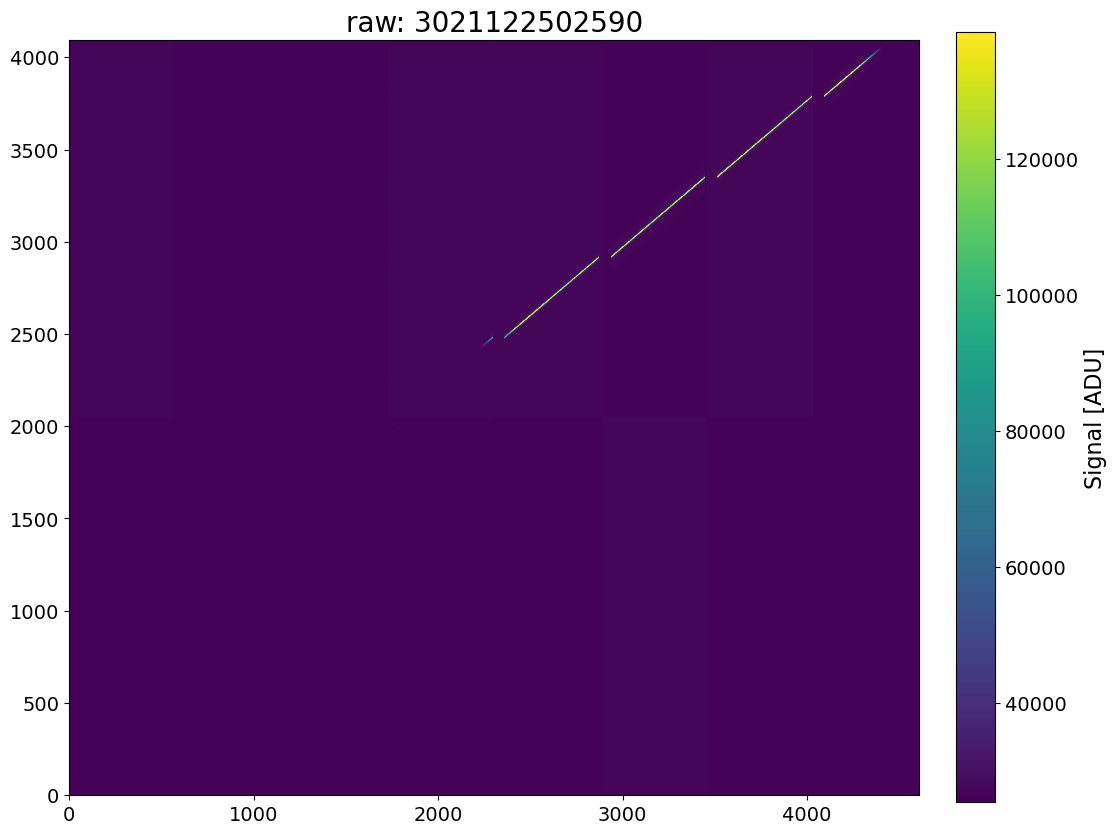

In [4]:
## Get single raw exposure
ref = dataset_refs[15]
rawexp = butler.get('raw', dataId=ref.dataId, collections=collections)

## Display raw image
fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')
im = ax.imshow(rawexp.getImage().getArray(), origin='lower', interpolation='none')

cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Signal [ADU]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('raw: {0}'.format(ref.dataId['exposure']), fontsize=20)

Calibration of the above raw image was performed using `lsst.ip.isr.isrTask.IsrTask`, which is part of the standard DM stack. This procedure consists of:

1. Overscan correction: A row-by-row subtraction of the image overscan signal.

2. Bias correction: Subtraction of an overscan corrected superbias image.

3. Gain correction (optional): Application of the amplifier gains, as derived from the Photon Transfer Curve.

4. Image Assembly: Assembly of the full CCD image from the individual amplifier images and trimming of overscan regions.

The corresponding calibrated exposure (`cpCrosstalkProc` dataset type) is displayed below. A symmetric logarithmic color scale is used in order to allow the induced crosstalk signal to be visible without the bright satellite streak saturating the color scale. Additionally, the segment boundaries have been plotted over the image in white.

Text(0.5, 1.0, 'cpCrosstalkProc: 3021122502590')

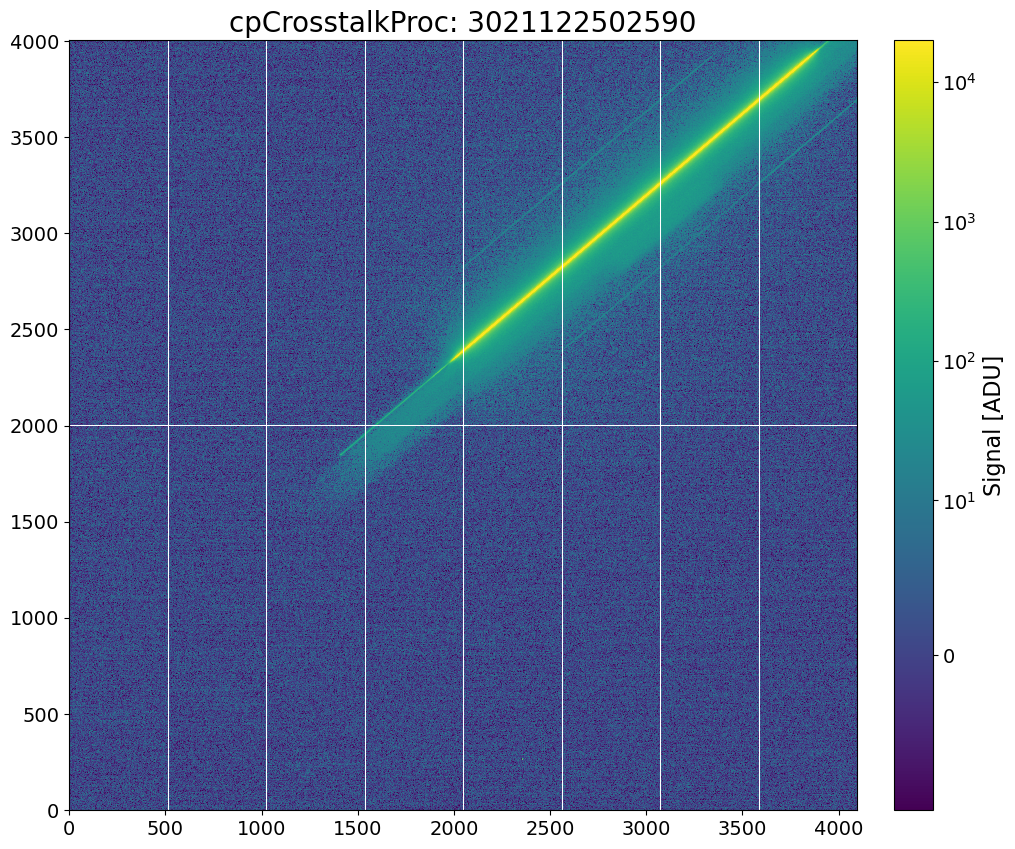

In [5]:
## Get single calibrated exposure
collections = 'u/snyder18/13241/crosstalk_satellite'
calexp = butler.get('cpCrosstalkProc', dataId=ref.dataId, collections=collections)

## Display calibrated image
fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')
im = ax.imshow(calexp.getImage().getArray(), interpolation='none', origin='lower',
               norm=SymLogNorm(10, vmin=-10, vmax=20000, base=10))

## Overplot segment boundaries
shape = calexp.getImage().getArray().shape
ax.axhline(y=shape[0]//2, color='white', linewidth=0.75)
for i in range(7):
    ax.axvline(x=(shape[1]//8)*(i+1), color='white', linewidth=0.75)
    
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Signal [ADU]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('cpCrosstalkProc: {0}'.format(ref.dataId['exposure']), fontsize=20)

## 2. Identify Satellite Streak Location

The next step is to detect the locatation of the projected streak in each amplifier, which will act as a source of crosstalk. This is accomplished using `mixcoatl.detectStreaks.DetectStreaksTask`.  This task identifies linear features in an image and uses a clustering algorithm to find pairs of lines corresponding to the sides of a single streak. For an indepth demonstration of the streak detection task see `Example_StreakDetection.ipynb`.

Once a streak is identified in the source amplifier, a mask is constructed around the streak region on both the source amplifier image and the target amplifier image, shown below. This is done to isolate the regions of the CCD that will be used to perform the crosstalk model fit.

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2023_15/conda/envs/lsst-scipipe-5.1.0-exact-ext/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


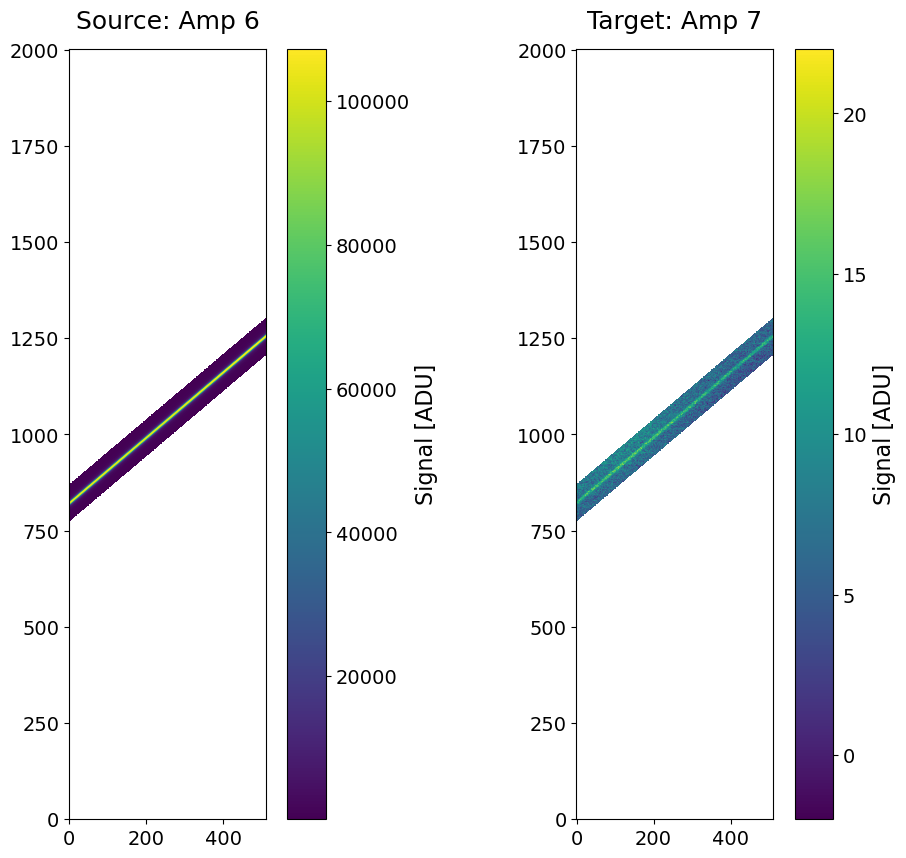

In [6]:
## Select source amplifier
detector = calexp.getDetector()
source_amp = detector[5]

## Get source amp image
source_im = calexp.getMaskedImage()
FootprintSet(source_im, Threshold(1000), "DETECTED")
detected = source_im.getMask().getPlaneBitMask("DETECTED")
source_amp_image = source_im[source_amp.getBBox()]
source_amp_array = source_amp_image.getImage().getArray()
source_amp_mask = source_amp_image.getMask().getArray()

## Run the streak detection task
detect_streaks_config = DetectStreaksTask.ConfigClass()
detect_streaks_task = DetectStreaksTask(config=detect_streaks_config)
detect_streaks_results = detect_streaks_task.run(source_amp_image)
source_mask = detect_streaks_results.sourceMask

## Construct model region mask
model_select = (source_mask & np.isfinite(source_amp_array))

## Get target amp image
target_amp = detector[6]
target_im = calexp.getMaskedImage()
target_amp_image = CrosstalkCalib.extractAmp(target_im, target_amp, source_amp, 
                                             isTrimmed=True)
target_amp_array = target_amp_image.getImage().getArray()

## Plot source/target regions
fig, ax = plt.subplots(1, 2, figsize=(12, 10))
im0 = ax[0].imshow(np.ma.MaskedArray(source_amp_array, mask=~model_select), origin='lower')
im1 = ax[1].imshow(np.ma.MaskedArray(target_amp_array, mask=~model_select), origin='lower', 
                   vmin=-2, vmax=22)

ax[0].set_title('Source: Amp {0}'.format(SEG2AMP[source_amp.getName()]), 
                fontsize=18, pad=15)
ax[0].tick_params(axis='both', which='major', labelsize=14)
cbar0 = fig.colorbar(im0, ax=ax[0])
cbar0.set_label('Signal [ADU]', fontsize=16)
cbar0.ax.tick_params(labelsize=14)

ax[1].set_title('Target: Amp {0}'.format(SEG2AMP[target_amp.getName()]), 
                fontsize=18, pad=15)
ax[1].tick_params(axis='both', which='major', labelsize=14)
cbar1 = fig.colorbar(im1, ax=ax[1])
cbar1.set_label('Signal [ADU]', fontsize=16)
cbar1.ax.tick_params(labelsize=14)

## 4. (Optional) Determine Read Noise Covariance

A systematic source of error in this measurement methodology is the effect of correlated read noise between amplifier pairs that will bias any pixel signal comparison between the image regions, most noticeably for low source signals. In order to remove this systematic, the correlation between the read noise is removed by adding an additional noise component to each image that is equal in magnitude but with the opposite correlation as the original read noise.  The covariance between the serial overscan regions, which will be used for the correction of the read noise correlation, is calculated using the `raw` exposure, which have not been trimmed of the overscan regions. A disadvantage of this technique is that it will increase the statistical error for each crosstalk ratio measurement, thus for amplifier pairs with little correlation in read noise it can be ommitted to improve the measurement error.

Below is the result of the covariance calculation for the amplifier pairs used in this example. In the absence of this measurement, the read noise will be extracted from the source/target `lsst.afw.cameraGeom.Amplifier` objects to be used in the model parameter error estimate results.

In [7]:
## Determine covariance matrix
covariance = mixCrosstalk.calculate_covariance(rawexp, source_amp, target_amp)
print('Covariance: Amp {0}, Amp {1}\n'.format(SEG2AMP[source_amp.getName()], 
                                              SEG2AMP[target_amp.getName()]), covariance)

Covariance: Amp 6, Amp 7
 [[14.35235676  0.44147905]
 [ 0.44147905 13.90849964]]


## 5. Least Squares Minimization of Target Model

The simplest method to calculate the crosstalk ratio is to simply take a ratio of the induced signal in the target amplifier region compared to the signal in the source amplifier region. However, because of the presence of a non-uniform scattered light background it is necessary to account for this additional signal when calculating the crosstalk ratio. 

Therefore the method used to measure the crosstalk is to assume that within the pixel region selected by the mask encompassing the satellite streak the target amplifier image is composed of:

* A linear crosstalk contribution parameterized by $c_0$ that scales the source signal $S$.
* A first-order non-linear crosstalk contribution parameterized by $c_1$ that scales the square of the source signal $S^2$.
* A background model formed as a linear combination of 2-D polynomials.

Using this model, a least squares minimization can be performed using `mixcoatl.crosstalk.CrosstalkModelFitTask` that solves jointly for the crosstalk and the scattered light background (https://arxiv.org/abs/2101.01281). This is demonstrated below with an image of the source region on the left, the target region in the center, and the best fit model determined from the least squares minimization on the right.

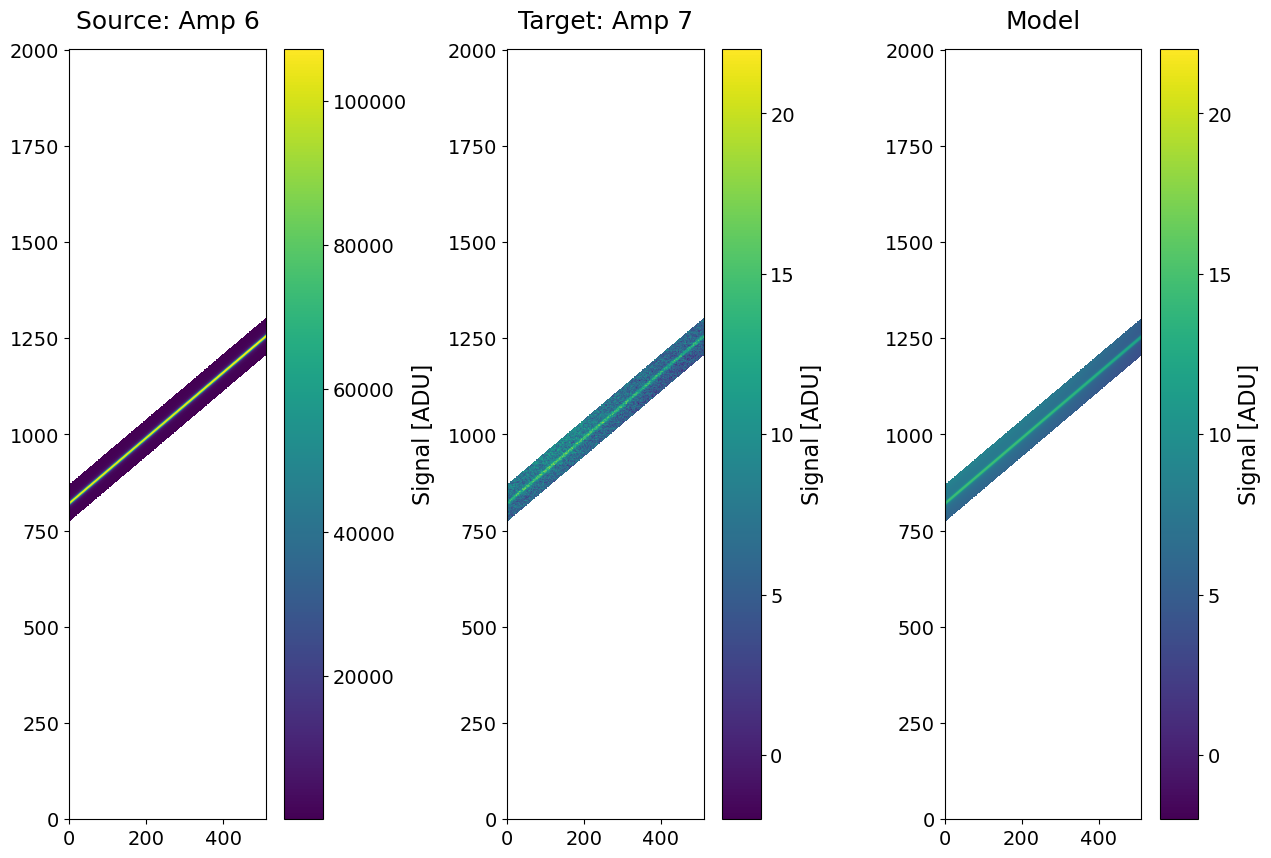

In [8]:
## Calculate best fit model results
model_fit_config = CrosstalkModelFitTask.ConfigClass()
model_fit_config.backgroundOrder = 2
model_fit_config.doNonLinearCrosstalk = True
model_fit_task = CrosstalkModelFitTask(config=model_fit_config)
model_fit_results = model_fit_task.run(source_amp_array, target_amp_array, model_select, 
                                       covariance, seed=189)

## Construct crosstalk model
crosstalk_params = model_fit_results.crosstalkResults
background_params = model_fit_results.backgroundResults
model = mixCrosstalk.crosstalk_model(crosstalk_params, background_params,
                                     source_amp_array)

## Plot source, target, and best fit model
fig, ax = plt.subplots(1, 3, figsize=(16, 10))
im0 = ax[0].imshow(np.ma.MaskedArray(source_amp_array, mask=~model_select), origin='lower')
im1 = ax[1].imshow(np.ma.MaskedArray(target_amp_array, mask=~model_select), origin='lower', 
                   vmin=-2, vmax=22)
im2 = ax[2].imshow(np.ma.MaskedArray(model, mask=~model_select), origin='lower', 
                   vmin=-2, vmax=22)

ax[0].set_title('Source: Amp {0}'.format(SEG2AMP[source_amp.getName()]), fontsize=18, pad=15)
ax[0].tick_params(axis='both', which='major', labelsize=14)
cbar0 = fig.colorbar(im0, ax=ax[0])
cbar0.set_label('Signal [ADU]', fontsize=16)
cbar0.ax.tick_params(labelsize=14)

ax[1].set_title('Target: Amp {0}'.format(SEG2AMP[target_amp.getName()]), fontsize=18, pad=15)
ax[1].tick_params(axis='both', which='major', labelsize=14)
cbar1 = fig.colorbar(im1, ax=ax[1])
cbar1.set_label('Signal [ADU]', fontsize=16)
cbar1.ax.tick_params(labelsize=14)

ax[2].set_title('Model', fontsize=18, pad=15)
ax[2].tick_params(axis='both', which='major', labelsize=14)
cbar2 = fig.colorbar(im2, ax=ax[2])
cbar2.set_label('Signal [ADU]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)

## 6. Calculate Pixel-by-Pixel Ratios

The final step is to calculate the pixel-by-pixel ratios using the background subtracted target region. Using the parameterization determined by the least squares minimization a background model can be constructed and subtracted from the target region. Then the pixel-by-pixel ratios can be calculated as the background subtracted target pixels divided by the source pixels, as a function of source pixel signal.

The background model and background subtracted target region are shown below.

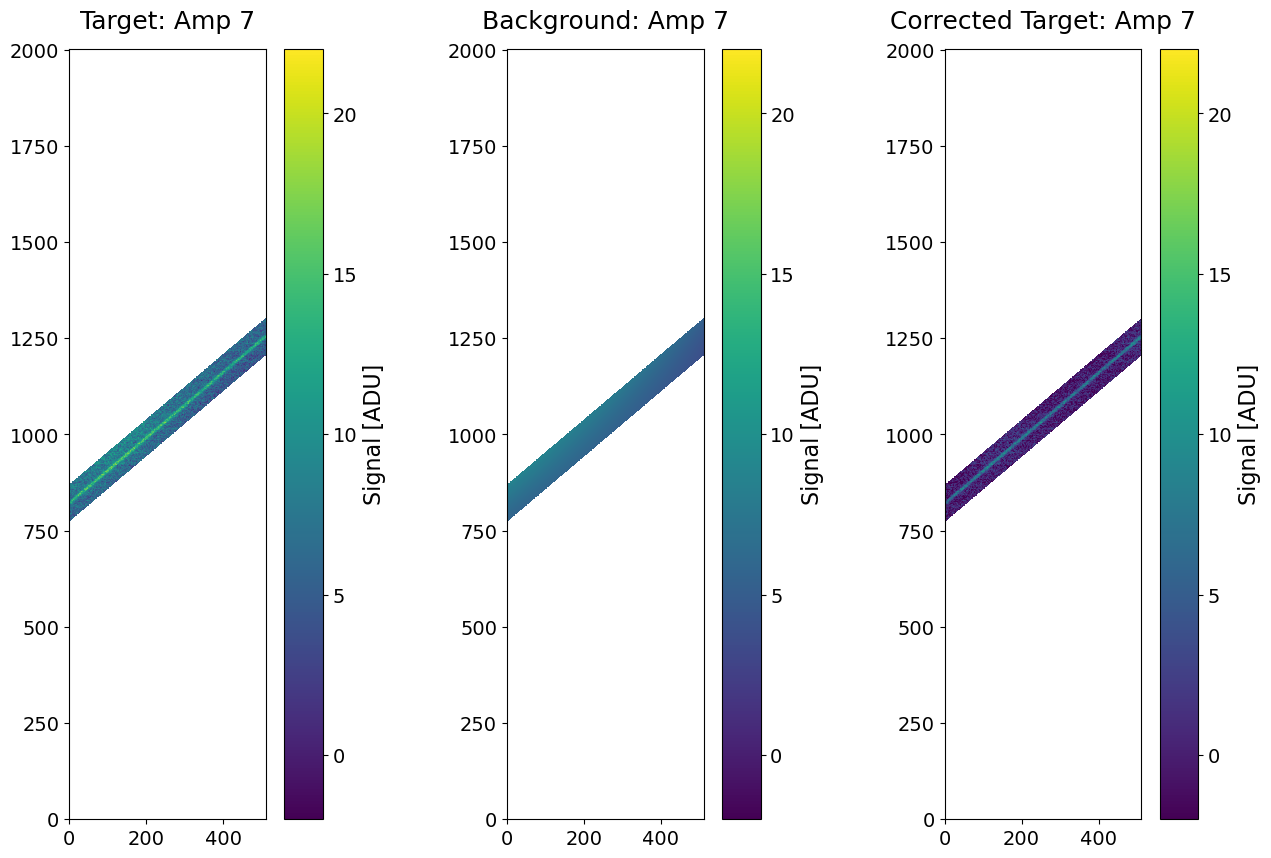

In [9]:
## Calculate background-subtracted target region
bg = mixCrosstalk.background_model(background_params, source_amp_array.shape)
bg_corrected = target_amp_array - bg

## Calculate pixel-by-pixel ratios
ratio_select = (model_select & (source_amp_mask & detected > 0))
ratios = (bg_corrected[ratio_select]/source_amp_array[ratio_select]).tolist()
fluxes = source_amp_array[ratio_select].tolist()

## Plot target, background, and background-subtracted target regions
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 10), facecolor='white')
im0 = ax0.imshow(np.ma.MaskedArray(target_amp_array, mask=~model_select), origin='lower',
                 vmin=-2, vmax=22)
im1 = ax1.imshow(np.ma.MaskedArray(bg, mask=~model_select), origin='lower',
                 vmin=-2, vmax=22)
im2 = ax2.imshow(np.ma.MaskedArray(bg_corrected, mask=~model_select), origin='lower',
                 vmin=-2, vmax=22)

ax0.set_title('Target: Amp {0}'.format(SEG2AMP[target_amp.getName()]), fontsize=18, pad=15)
ax0.tick_params(axis='both', which='major', labelsize=14)
cbar0 = fig.colorbar(im0, ax=ax0)
cbar0.set_label('Signal [ADU]', fontsize=16)
cbar0.ax.tick_params(labelsize=14)

ax1.set_title('Background: Amp {0}'.format(SEG2AMP[target_amp.getName()]), fontsize=18, pad=15)
ax1.tick_params(axis='both', which='major', labelsize=14)
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.set_label('Signal [ADU]', fontsize=16)
cbar1.ax.tick_params(labelsize=14)

ax2.set_title('Corrected Target: Amp {0}'.format(SEG2AMP[target_amp.getName()]), fontsize=18, pad=15)
ax2.tick_params(axis='both', which='major', labelsize=14)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.set_label('Signal [ADU]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)

# Final Results

Finally, we plot both the pixel-by-pixel ratio results (after binning) as a function of source signal and the crosstalk model fit parameterization results.

Text(0.5, 1.0, 'Crosstalk Results: 3021122502590')

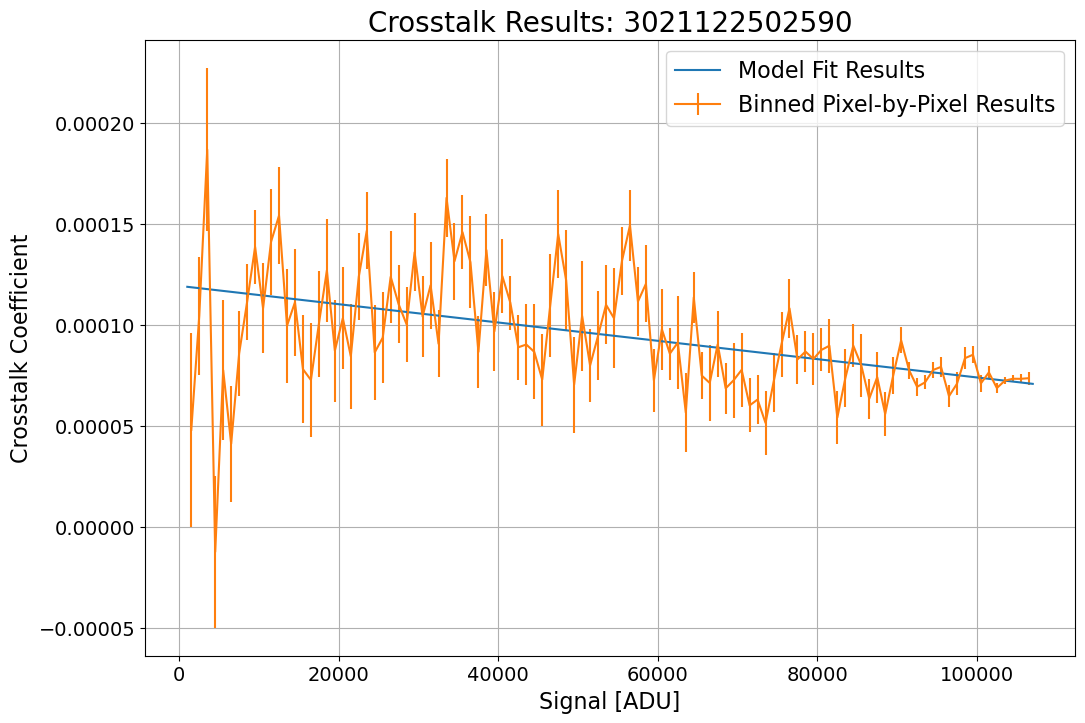

In [10]:
## Bin pixel-by-pixel ratios
bins = np.arange(1000, np.max(fluxes), 1000)
bin_coefficients, bin_edges, binnumber = binned_statistic(fluxes, ratios, statistic='median', 
                                           bins=bins)
bin_std, bin_edges, binnumber = binned_statistic(fluxes, ratios, statistic='std', 
                                           bins=bins)
bin_count, bin_edges, binnumber = binned_statistic(fluxes, ratios, statistic='count', 
                                           bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

## Crosstalk model coefficients
c0 = crosstalk_params['c0']
c1 = crosstalk_params['c1']

## Plot raw pixel-by-pixel ratios
fig, ax = plt.subplots(1, 1, figsize=(12, 8), facecolor='white')
ax.errorbar(bin_centers, bin_coefficients, yerr=bin_std/np.sqrt(bin_count), 
             c='C01', label='Binned Pixel-by-Pixel Results')
ax.plot(bins, c0 + bins*c1, label='Model Fit Results')

ax.legend(fontsize=16)
ax.grid()
ax.set_ylabel('Crosstalk Coefficient', fontsize=16)
ax.set_xlabel('Signal [ADU]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('Crosstalk Results: {0}'.format(ref.dataId['exposure']), fontsize=20)